In [144]:
from __future__ import division
from tensorflow.keras.utils import Sequence
import sys
import numpy as np
from numpy.random import seed, randint
from scipy.io import wavfile
from sklearn import svm
import linecache
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
# from vggish import VGGish
from preprocess_sound import preprocess_sound
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [17]:
from __future__ import print_function
from __future__ import absolute_import

import sys
import h5py
import keras


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D

# Adjusting the import for TensorFlow Keras
from tensorflow.keras.utils import get_source_inputs
from tensorflow.keras import backend as K

import vggish_params as params


# weight path
WEIGHTS_PATH = r'C:\Users\Mohamed ali\PFE\vggish_audioset_weights_without_fc2.h5'

In [18]:
def VGGish(load_weights=True, weights='audioset',
           input_tensor=None, input_shape=None,
           out_dim=None, include_top=True, pooling='avg'):
    '''
    An implementation of the VGGish architecture.

    :param load_weights: if load weights
    :param weights: loads weights pre-trained on a preliminary version of YouTube-8M.
    :param input_tensor: input_layer
    :param input_shape: input data shape
    :param out_dim: output dimension
    :param include_top:whether to include the 3 fully-connected layers at the top of the network.
    :param pooling: pooling type over the non-top network, 'avg' or 'max'

    :return: A Keras model instance.
    '''

    if weights not in {'audioset', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `audioset` '
                         '(pre-training on audioset).')

    if out_dim is None:
        out_dim = params.EMBEDDING_SIZE

    # input shape
    if input_shape is None:
        input_shape = (params.NUM_FRAMES, params.NUM_BANDS, 1)

    if input_tensor is None:
        aud_input = Input(shape=input_shape, name='input_1')
    else:
        if not K.is_keras_tensor(input_tensor):
            aud_input = Input(tensor=input_tensor, shape=input_shape, name='input_1')
        else:
            aud_input = input_tensor



    # Block 1
    x = Conv2D(64, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv1')(aud_input)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool1')(x)

    # Block 2
    x = Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool2')(x)

    # Block 3
    x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv3/conv3_1')(x)
    x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv3/conv3_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool3')(x)

    # Block 4
    x = Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv4/conv4_1')(x)
    x = Conv2D(512, (3, 3), strides=(1, 1), activation='relu', padding='same', name='conv4/conv4_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool4')(x)



    if include_top:
        # FC block
        x = Flatten(name='flatten_')(x)
        x = Dense(4096, activation='relu', name='vggish_fc1/fc1_1')(x)
        x = Dense(4096, activation='relu', name='vggish_fc1/fc1_2')(x)
        x = Dense(out_dim, activation='relu', name='vggish_fc2')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)


    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = aud_input
    # Create model.
    model = Model(inputs, x, name='VGGish')


    # load weights
    if load_weights:
        if weights == 'audioset':
            if include_top:
                model.load_weights(WEIGHTS_PATH_TOP)
            else:
                model.load_weights(r'C:\Users\Mohamed ali\PFE\vggish_audioset_weights_without_fc2.h5')
        else:
            print("failed to load weights")

    return model

In [26]:
# matesta3melhach mechi riglo
def loading_data(files, sound_extractor):


    lines = linecache.getlines(files)
    sample_num = len(lines)
    seg_num = 60
    seg_len = 5  # 5s
    data = np.zeros((seg_num * sample_num, 496, 64, 1))
    label = np.zeros((seg_num * sample_num,))

    for i in range(len(lines)):
        sound_file = '/mount/hudi/moe/sound_dataset/dcase/' + lines[i][:-7]
        sr, wav_data = wavfile.read(sound_file)

        length = sr * seg_len           # 5s segment
        range_high = len(wav_data) - length
        seed(1)  # for consistency and replication
        random_start = randint(range_high, size=seg_num)

        for j in range(seg_num):
            cur_wav = wav_data[random_start[j]:random_start[j] + length]
            cur_wav = cur_wav / 32768.0
            cur_spectro = preprocess_sound(cur_wav, sr)
            cur_spectro = np.expand_dims(cur_spectro, 3)
            data[i * seg_num + j, :, :, :] = cur_spectro
            label[i * seg_num + j] = lines[i][-2]

    data = sound_extractor.predict(data)

    return data, label

In [126]:
class AudioDataGenerator(Sequence):
    def __init__(self, data_dir, batch_size, preprocessing_function, subset='train'):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.preprocessing_function = preprocessing_function
        self.subset = subset
        self.classes = sorted(os.listdir(os.path.join(data_dir, subset)))
        self.num_classes = len(self.classes)
        self.indices = self._get_file_indices()
        
    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size: (index + 1) * self.batch_size]
        X, y = self._load_batch(batch_indices)
        
        # Convert NumPy arrays to TensorFlow tensors
        X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
        y_tensor = tf.convert_to_tensor(y, dtype=tf.float32)  # Adjust the dtype if necessary
        
        # Remove the singleton dimension if needed
        X_tensor = tf.squeeze(X_tensor, axis=1)
        
        #print(X_tensor.shape)
        
        return X_tensor, y_tensor
    
    def _get_file_indices(self):
        indices = []
        class_counts = {}  # Dictionary to store the count of samples for each class
        
        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.data_dir, self.subset, class_name)
            file_names = os.listdir(class_dir)
            class_indices = [(i, os.path.join(class_dir, file_name)) for file_name in file_names]
            indices.extend(class_indices)
            class_counts[class_name] = len(file_names)  # Store the count of samples for the current class
        
        # Print the count of samples for each class
        for class_name, count in class_counts.items():
            print(f"Class '{class_name}' has {count} samples.")
        print(str(len(indices))," of files for ",str(self.num_classes)," classes ... ",self.classes)
        return indices
    
    def _load_batch(self, batch_indices):
        X = []
        y = []
        for class_index, file_path in batch_indices:
            # Load audio data and label here (e.g., using librosa)
            # Example:
            # audio_data, sr = librosa.load(file_path, sr=None)
            # label = class_index
            # Append loaded data and label to X and y lists
            X.append(self.preprocessing_function(file_path))
            y.append(class_index)
        return np.array(X), np.array(y)

In [161]:
# Define your preprocessing function
def preprocess_audio(audio_path):
    sr, wav_data = wavfile.read(audio_path)
    cur_wav = wav_data / 32768.0
    cur_spectro = preprocess_sound(cur_wav, sr)
    cur_spectro = np.expand_dims(cur_spectro, 3)
    return cur_spectro

In [163]:
path=r'A:\AI DB\LSPD\audio_pret\train\porn\porn_4_segment_12_sr16000.wav'
processed_audio=preprocess_audio(path)
print(processed_audio.shape)

(1, 96, 64, 1)


In [123]:
sound_model = VGGish(include_top=False, load_weights=True, weights='audioset', pooling='avg')

x = sound_model.get_layer(name="conv4/conv4_2").output
output_layer = GlobalAveragePooling2D()(x)
sound_extractor = Model(inputs=sound_model.input, outputs=output_layer)
# Set all layers in sound_model to not trainable
for layer in sound_model.layers:
    layer.trainable = False

# Add dense layer with 256 units and ReLU activation
dense_layer = Dense(256, activation='relu')(output_layer)

# Add dropout layer with a dropout rate of 0.5
dropout_layer = Dropout(0.5)(dense_layer)

# Add output layer with 1 unit and sigmoid activation (for binary classification)
output = Dense(1, activation='sigmoid')(dropout_layer)

# Create the final model
sound_model_with_output = Model(inputs=sound_model.input, outputs=output)

# Compile the model
sound_model_with_output.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


In [124]:
checkpoint = ModelCheckpoint(r'A:\AI DB\LSPD\models\audioModel.keras', monitor='val_loss', save_best_only=True, mode='min')


In [67]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)

# Convert class weights to a dictionary format with numeric keys
class_weights_dict = dict(enumerate(class_weights))
# Verify the dictionary
print(class_weights_dict)

{0: 1.0, 1: 1.0}


In [31]:
sound_model_with_output.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 64, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 96, 64, 64)        640       
                                                                 
 pool1 (MaxPooling2D)        (None, 48, 32, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 48, 32, 128)       73856     
                                                                 
 pool2 (MaxPooling2D)        (None, 24, 16, 128)       0         
                                                                 
 conv3/conv3_1 (Conv2D)      (None, 24, 16, 256)       295168    
                                                                 
 conv3/conv3_2 (Conv2D)      (None, 24, 16, 256)       5900

In [127]:
# Create train, validation, and test generators
train_generator = AudioDataGenerator(data_dir=r'A:\AI DB\LSPD\audio_pret', 
                                     batch_size=32, 
                                     preprocessing_function=preprocess_audio, 
                                     subset='train')
val_generator = AudioDataGenerator(data_dir=r'A:\AI DB\LSPD\audio_pret', 
                                   batch_size=32, 
                                   preprocessing_function=preprocess_audio, 
                                   subset='val')
test_generator = AudioDataGenerator(data_dir=r'A:\AI DB\LSPD\audio_pret', 
                                    batch_size=32, 
                                    preprocessing_function=preprocess_audio, 
                                    subset='test')

Class 'normal' has 88643 samples.
Class 'porn' has 128562 samples.
217205  of files for  2  classes ...  ['normal', 'porn']
Class 'normal' has 4924 samples.
Class 'porn' has 7142 samples.
12066  of files for  2  classes ...  ['normal', 'porn']
Class 'normal' has 4926 samples.
Class 'porn' has 7143 samples.
12069  of files for  2  classes ...  ['normal', 'porn']


In [129]:
# 5. Fit the Model
history = sound_model_with_output.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=checkpoint
)

Epoch 1/20
6788/6788 [==============================] - 991s 146ms/step - loss: 0.4891 - accuracy: 0.7849 - val_loss: 0.3712 - val_accuracy: 0.8490
Epoch 2/20
6788/6788 [==============================] - 696s 103ms/step - loss: 0.3450 - accuracy: 0.8536 - val_loss: 0.3298 - val_accuracy: 0.8594
Epoch 3/20
6788/6788 [==============================] - 744s 110ms/step - loss: 0.3193 - accuracy: 0.8624 - val_loss: 0.3151 - val_accuracy: 0.8633
Epoch 4/20
6788/6788 [==============================] - 297s 44ms/step - loss: 0.3066 - accuracy: 0.8670 - val_loss: 0.3039 - val_accuracy: 0.8663
Epoch 5/20
6788/6788 [==============================] - 296s 44ms/step - loss: 0.2965 - accuracy: 0.8716 - val_loss: 0.3072 - val_accuracy: 0.8673
Epoch 6/20
6788/6788 [==============================] - 295s 44ms/step - loss: 0.2908 - accuracy: 0.8743 - val_loss: 0.2918 - val_accuracy: 0.8713
Epoch 7/20
6788/6788 [==============================] - 291s 43ms/step - loss: 0.2847 - accuracy: 0.8771 - val_loss

In [149]:
# Unfreeze the last 4 layers
for layer in sound_model.layers[-4:]:
    layer.trainable = True

sound_model_with_output.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint(r'A:\AI DB\LSPD\models\audioModelUnfreeze.keras', monitor='val_loss', save_best_only=True, mode='min')
sound_model_with_output.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 64, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 96, 64, 64)        640       
                                                                 
 pool1 (MaxPooling2D)        (None, 48, 32, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 48, 32, 128)       73856     
                                                                 
 pool2 (MaxPooling2D)        (None, 24, 16, 128)       0         
                                                                 
 conv3/conv3_1 (Conv2D)      (None, 24, 16, 256)       295168    
                                                                 
 conv3/conv3_2 (Conv2D)      (None, 24, 16, 256)       590

In [151]:
# 5. Fit the Model
history = sound_model_with_output.fit(
    train_generator,
    validation_data=val_generator,
    initial_epoch=19,
    epochs=40,
    callbacks=checkpoint
)

Epoch 20/40
6788/6788 [==============================] - 303s 44ms/step - loss: 0.2411 - accuracy: 0.8981 - val_loss: 0.2302 - val_accuracy: 0.9020
Epoch 21/40
6788/6788 [==============================] - 297s 44ms/step - loss: 0.2125 - accuracy: 0.9122 - val_loss: 0.2084 - val_accuracy: 0.9135
Epoch 22/40
6788/6788 [==============================] - 294s 43ms/step - loss: 0.1923 - accuracy: 0.9219 - val_loss: 0.1967 - val_accuracy: 0.9199
Epoch 23/40
6788/6788 [==============================] - 295s 43ms/step - loss: 0.1773 - accuracy: 0.9294 - val_loss: 0.1865 - val_accuracy: 0.9235
Epoch 24/40
6788/6788 [==============================] - 302s 45ms/step - loss: 0.1646 - accuracy: 0.9347 - val_loss: 0.1771 - val_accuracy: 0.9283
Epoch 25/40
6788/6788 [==============================] - 298s 44ms/step - loss: 0.1541 - accuracy: 0.9398 - val_loss: 0.1692 - val_accuracy: 0.9309
Epoch 26/40
6788/6788 [==============================] - 295s 44ms/step - loss: 0.1447 - accuracy: 0.9439 - val_

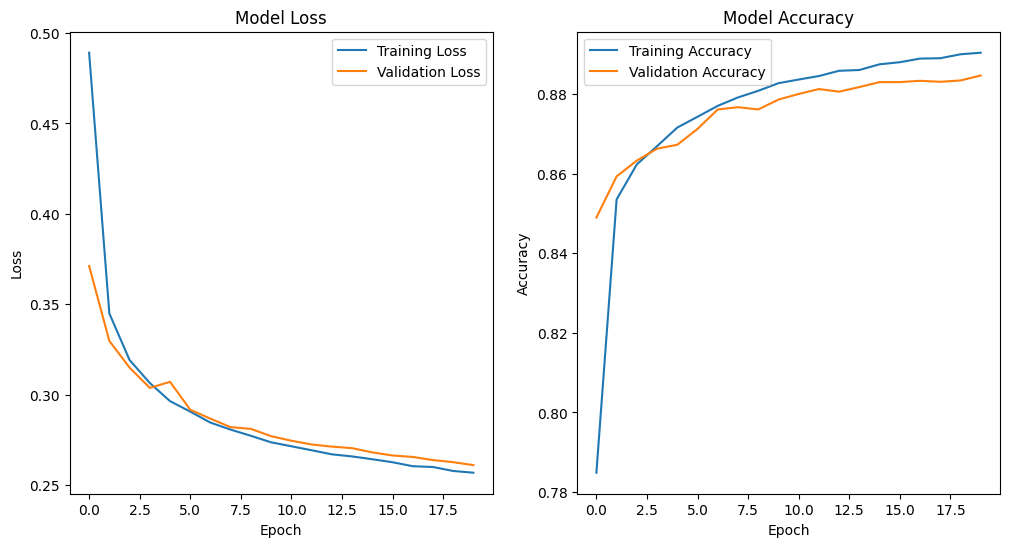

In [148]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

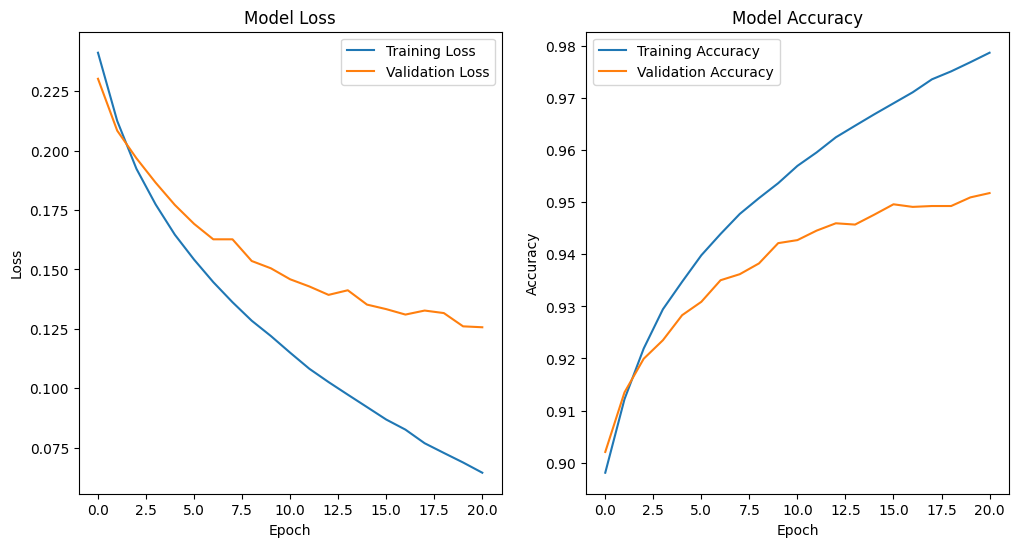

In [152]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [153]:
# Predict on the test set
ypred = sound_model_with_output.predict(test_generator)

378/378 [==============================] - 52s 137ms/step


In [146]:
y_true_classes = [class_index for class_index, _ in test_generator.indices]


In [154]:
from sklearn.metrics import accuracy_score, f1_score

ypred_prob=ypred
# Define a list of threshold values to test
threshold_values = np.arange(0.01, 1.0, 0.01)

# Initialize lists to store evaluation metrics
accuracy_scores = []

f1_scores = []

# Iterate through each threshold value
for threshold in threshold_values:
    # Convert predicted probabilities to binary predictions based on the threshold
    y_pred_classes = (ypred_prob > threshold).astype(int)
    
    # Calculate accuracy score
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    accuracy_scores.append(accuracy)
    
    # Calculate F1 score
    f1 = f1_score(y_true_classes, y_pred_classes)
    f1_scores.append(f1)

# Find the index of the threshold with the highest accuracy score
best_accuracy_index = np.argmax(accuracy_scores)
best_accuracy_threshold = threshold_values[best_accuracy_index]
best_accuracy = accuracy_scores[best_accuracy_index]

# Find the index of the threshold with the highest F1 score
best_f1_index = np.argmax(f1_scores)
best_f1_threshold = threshold_values[best_f1_index]
best_f1 = f1_scores[best_f1_index]

print("Best Accuracy:")
print("Threshold:", best_accuracy_threshold)
print("Accuracy Score:", best_accuracy)

print("\nBest F1 Score:")
print("Threshold:", best_f1_threshold)
print("F1 Score:", best_f1)


Best Accuracy:
Threshold: 0.65
Accuracy Score: 0.9502029994200016

Best F1 Score:
Threshold: 0.65
F1 Score: 0.957780119423955


Classification Report:
               precision    recall  f1-score   support

           0     0.9345    0.9442    0.9393      4926
           1     0.9612    0.9544    0.9578      7143

    accuracy                         0.9502     12069
   macro avg     0.9479    0.9493    0.9485     12069
weighted avg     0.9503    0.9502    0.9502     12069



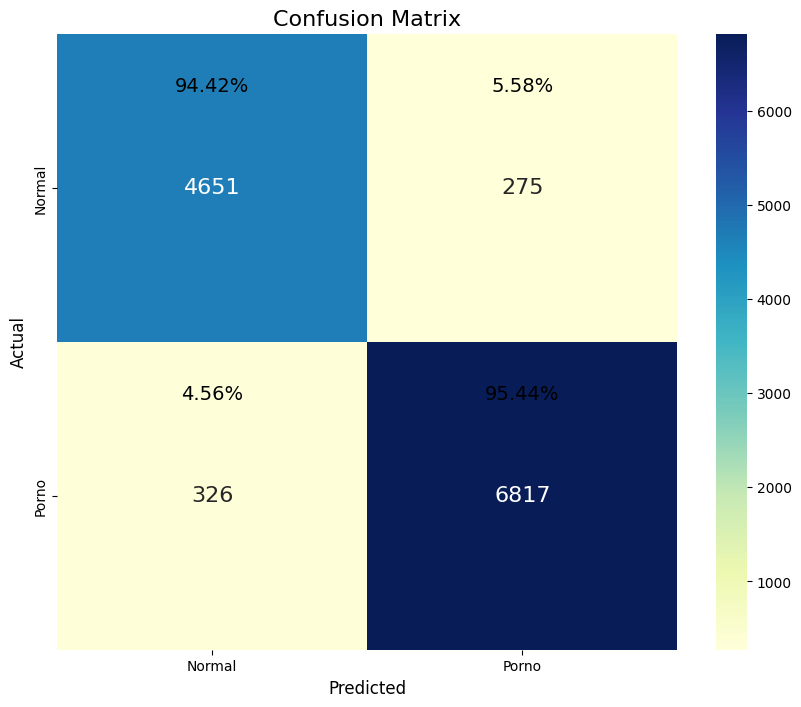

Accuracy Score: 0.9502
F1 Score: 0.9578


In [156]:
# Convert predicted probabilities to binary predictions
y_pred_classes = (ypred >  0.65).astype(int)

# Get actual classes
y_true_classes = [class_index for class_index, _ in test_generator.indices]

# Create a confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Generate a classification report
cr = classification_report(y_true_classes, y_pred_classes,digits=4)
print("Classification Report:\n", cr)

# Plot the confusion matrix with annotations positioned at the bottom
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Normal', 'Porno'], yticklabels=['Normal', 'Porno'], annot_kws={'size': 16})

# Add custom annotations at the bottom of each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.2, '{:.2f}%'.format(cm_normalized[i, j] * 100), ha='center', va='bottom', color='black', fontsize=14)

plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# Calculate accuracy score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print("Accuracy Score:", format(accuracy, '.4f'))

# Calculate F1 score
f1 = f1_score(y_true_classes, y_pred_classes)
print("F1 Score:", format(f1, '.4f'))